In [14]:
# ImportING dependencies
import matplotlib.pyplot as plt
import numpy as np
from collections import deque
import random
import heapq
import math
import time
import networkx as nx
from IPython.display import display, clear_output
import pandas as pd



# SCHEDULING ALGORITHMS

###Round Robin

In [ ]:

computers = ["Comp-A", "Comp-B", "Comp-C"]
tasks = [f"Task-{i}" for i in range(1, 7)]

# Random execution times (1–10 units)
exec_time = [random.randint(1,10) for _ in tasks]

# Round-robin assignment
assign = [computers[i%3] for i in range(len(tasks))]
print("Task Assignments:")
for t, c, e in zip(tasks, assign, exec_time):
    print(f"  {t} ({e} units) → {c}")

# Simulate finish times (each computer processes its tasks sequentially)
finish = [0]*3
for i, (t, e) in enumerate(zip(tasks, exec_time)):
    comp_idx = i % 3
    start = finish[comp_idx]
    finish[comp_idx] += e

completion_times = []
for i, e in enumerate(exec_time):
    comp_idx = i % 3
    start = finish[comp_idx] - e          # back-calculate start
    completion_times.append(finish[comp_idx])

# Metrics
total_time   = max(finish)
avg_latency  = sum(completion_times) / len(tasks)          # arrival = 0
throughput   = len(tasks) / total_time
net_efficiency = 100 * (len(tasks)*1024) / (len(tasks)*(1024+64))  # 1 KB task + 64 B overhead

print(" Metrics ")

print(f"Avg latency : {avg_latency:.2f} time units")
print(f"Throughput    : {throughput:.2f} tasks/unit time")
print(f"Net efficiency: {net_efficiency:.1f}%")

Task Assignments:
  Task-1 (9 units) → Comp-A
  Task-2 (8 units) → Comp-B
  Task-3 (2 units) → Comp-C
  Task-4 (8 units) → Comp-A
  Task-5 (3 units) → Comp-B
  Task-6 (1 units) → Comp-C
 *Metrics* 
Avg latency : 10.33 time units
Throughput    : 0.35 tasks/unit time
Net efficiency: 94.1%


###Shortest Job First

In [ ]:
import random

nodes = ["N1", "N2", "N3"]
tasks = sorted([random.randint(1,10) for _ in range(8)])
finish = {n: 0 for n in nodes}
completion = []

print("\nSJF Scheduling")
for t in tasks:
    node = min(finish, key=finish.get)   # pick least-loaded node
    finish[node] += t
    completion.append(finish[node])
    print(f"Task({t}) → {node}, done at {finish[node]}")

lat = sum(completion)/len(completion)
thr = len(tasks)/max(finish.values())
eff = 100*(1024/(1024+64))

print(f"\nLatency: {lat:.2f}, Throughput: {thr:.2f}, Efficiency: {eff:.1f}%")



SJF Scheduling
Task(1) → N1, done at 1
Task(3) → N2, done at 3
Task(4) → N3, done at 4
Task(5) → N1, done at 6
Task(7) → N2, done at 10
Task(7) → N3, done at 11
Task(7) → N1, done at 13
Task(10) → N2, done at 20

Latency: 8.50, Throughput: 0.40, Efficiency: 94.1%


### Priority scheduling

In [ ]:
import random

nodes = ["N1", "N2", "N3"]
tasks = [(random.randint(1,10), random.randint(1,3)) for _ in range(8)]
tasks.sort(key=lambda x: x[1])           # sort by priority (low = high priority)

finish = {n: 0 for n in nodes}
completion = []

print("\nPriority Scheduling")
for exec_t, pr in tasks:
    node = min(finish, key=finish.get)
    finish[node] += exec_t
    completion.append(finish[node])
    print(f"Exec={exec_t}, P={pr} → {node}, done at {finish[node]}")

lat = sum(completion)/len(completion)
thr = len(tasks)/max(finish.values())
eff = 100*(1024/(1024+64))

print(f"\nLatency: {lat:.2f}, Throughput: {thr:.2f}, Efficiency: {eff:.1f}%")



Priority Scheduling
Exec=8, P=1 → N1, done at 8
Exec=7, P=1 → N2, done at 7
Exec=9, P=1 → N3, done at 9
Exec=1, P=1 → N2, done at 8
Exec=2, P=1 → N1, done at 10
Exec=4, P=1 → N2, done at 12
Exec=4, P=1 → N3, done at 13
Exec=1, P=2 → N1, done at 11

Latency: 9.75, Throughput: 0.62, Efficiency: 94.1%


# CORDINATION AND SYNCHRONIZATION ALGORITHMS

### Bully algorithm

In [4]:
##Python Simulation: Bully Algorithm

class Node:
    def __init__(self, node_id, total_nodes):
        self.id = node_id
        self.total_nodes = total_nodes
        self.alive = True
        self.leader = None
        self.election_in_progress = False

    def fail(self):
        self.alive = False

    def recover(self):
        self.alive = True
        self.leader = None

    def start_election(self, nodes):
        if not self.alive:
            return
        self.election_in_progress = True
        higher_nodes = [n for n in nodes if n.id > self.id and n.alive]
        if not higher_nodes:
            # I am the leader
            self.leader = self.id
            for n in nodes:
                if n.alive:
                    n.leader = self.id
            self.election_in_progress = False
        else:
            # Send ELECTION to higher nodes
            for n in higher_nodes:
                n.receive_election(self.id, nodes)

    def receive_election(self, from_id, nodes):
        if not self.alive:
            return
        # Acknowledge and start own election
        self.start_election(nodes)

def simulate_bully():
    N = 5
    nodes = [Node(i, N) for i in range(N)]

    # Assume highest node (4) is initial leader
    for n in nodes:
        n.leader = 4

    # Simulate failure of leader
    nodes[4].fail()

    # Node 2 detects failure and starts election
    nodes[2].start_election(nodes)

    # Check final leader
    leaders = {n.leader for n in nodes if n.alive}
    return leaders.pop() if len(leaders) == 1 else None

print("Elected Leader (Bully):", simulate_bully())


Elected Leader (Bully): 3


###Token-Based Algorithm (Suzuki–Kasami)

In [5]:

# Parameters
# ----------------------------
NUM_NODES = 4
MAX_CS_PER_NODE = 2
SIM_ROUNDS = 50

# Global message pool
messages = []

def send_msg(src, dst, msg_type, payload):
    messages.append((dst, src, msg_type, payload))

class SuzukiKasamiNode:
    def __init__(self, node_id, total_nodes):
        self.id = node_id
        self.N = total_nodes
        # RN[i] = largest seq# received from node i
        self.RN = [0] * total_nodes
        self.requested = False
        self.in_cs = False
        self.has_token = (node_id == 0)  # node 0 starts with token
        self.token_queue = deque()
        self.LN = [0] * total_nodes  # LN[i] = last seq# satisfied for node i
        self.cs_count = 0

    def request_cs(self):
        if self.cs_count >= MAX_CS_PER_NODE:
            return
        if self.has_token and not self.requested:
            # Can enter immediately if token held and not already requested
            self.enter_cs()
        elif not self.requested:
            self.requested = True
            self.RN[self.id] += 1
            req_num = self.RN[self.id]
            # Broadcast REQUEST to all others
            for i in range(self.N):
                if i != self.id:
                    send_msg(self.id, i, 'REQUEST', req_num)

    def receive_msg(self, sender, msg_type, payload):
        if msg_type == 'REQUEST':
            req_num = payload
            if req_num > self.RN[sender]:
                self.RN[sender] = req_num
            # If I have token and not in CS, try to forward
            if self.has_token and not self.in_cs:
                self.try_forward_token()
        elif msg_type == 'TOKEN':
            self.has_token = True
            self.token_queue = deque(payload['queue'])
            self.LN = payload['LN'].copy()
            self.try_enter_cs()

    def try_enter_cs(self):
        if self.has_token and self.requested:
            if self.RN[self.id] == self.LN[self.id] + 1:
                self.enter_cs()

    def enter_cs(self):
        self.in_cs = True
        self.cs_count += 1
        # Simulate CS execution (no delay in logical sim)
        self.in_cs = False
        self.LN[self.id] = self.RN[self.id]
        self.requested = False
        # Forward token
        self.try_forward_token()

    def try_forward_token(self):
        if not self.has_token or self.in_cs:
            return
        # Find eligible node: RN[i] == LN[i] + 1
        next_holder = None
        for i in range(self.N):
            if i != self.id and self.RN[i] == self.LN[i] + 1:
                next_holder = i
                break
        if next_holder is None:
            # No one waiting; keep token
            return
        # Prepare token
        token_payload = {
            'queue': [],  # Suzuki-Kasami doesn't actually need explicit queue if RN/LN used correctly
            'LN': self.LN.copy()
        }
        self.has_token = False
        send_msg(self.id, next_holder, 'TOKEN', token_payload)

# ----------------------------
# Simulation Driver
# ----------------------------
def simulate_suzuki_kasami():
    global messages
    nodes = [SuzukiKasamiNode(i, NUM_NODES) for i in range(NUM_NODES)]
    total_msgs = 0
    cs_entries = 0

    for _ in range(SIM_ROUNDS):
        messages.clear()
        # Each node may request CS
        for node in nodes:
            node.request_cs()
        total_msgs += len(messages)

        # Deliver messages
        for (dst, src, mtype, payload) in messages:
            nodes[dst].receive_msg(src, mtype, payload)
            total_msgs += 1  # count delivery

        cs_entries = sum(n.cs_count for n in nodes)
        if all(n.cs_count >= MAX_CS_PER_NODE for n in nodes):
            break

    return {
        'algorithm': 'Suzuki-Kasami (Fixed)',
        'total_cs_entries': cs_entries,
        'total_messages': total_msgs,
        'avg_msg_per_cs': total_msgs / max(cs_entries, 1)
    }

# Run
result = simulate_suzuki_kasami()
print(result)


{'algorithm': 'Suzuki-Kasami (Fixed)', 'total_cs_entries': 8, 'total_messages': 42, 'avg_msg_per_cs': 5.25}


###Ricart–Agrawala Algorithm Simulation

In [7]:

# Configuration
# ----------------------------
NUM_NODES = 4
MAX_CS_PER_NODE = 2  # Each node enters CS this many times
SIM_MAX_ROUNDS = 100

# ----------------------------
# Node Class: Ricart–Agrawala
# ----------------------------
class RicartAgrawalaNode:
    def __init__(self, node_id, total_nodes):
        self.id = node_id
        self.total_nodes = total_nodes
        self.clock = 0
        self.request_queue = []  # min-heap of (timestamp, node_id)
        self.deferred_replies = set()  # set of node IDs we owe a reply to
        self.in_cs = False
        self.cs_count = 0
        self.requested = False  # whether we've requested CS and not yet entered

    def increment_clock(self):
        self.clock += 1

    def request_cs(self):
        """Initiate CS request if not already done"""
        if self.cs_count >= MAX_CS_PER_NODE or self.requested:
            return
        self.increment_clock()
        self.requested = True
        heapq.heappush(self.request_queue, (self.clock, self.id))
        # Broadcast REQUEST to all other nodes
        for i in range(self.total_nodes):
            if i != self.id:
                send_message(self.id, i, 'REQUEST', (self.clock, self.id))

    def receive_message(self, sender_id, msg_type, content):
        """Handle incoming messages"""
        self.increment_clock()
        if msg_type == 'REQUEST':
            ts, req_id = content
            # Add to queue
            heapq.heappush(self.request_queue, (ts, req_id))
            # Decide whether to reply now or defer
            # Check: is there a request in queue with higher priority (lower (ts, id)) than (ts, req_id)?
            # Ricart–Agrawala rule:
            #   Reply immediately if:
            #     (a) I am not in CS, AND
            #     (b) I have no pending request with (my_ts, my_id) < (ts, req_id)
            my_pending = (self.requested and self.request_queue and self.request_queue[0][1] == self.id)
            if not self.in_cs and not my_pending:
                # Safe to reply
                send_message(self.id, sender_id, 'REPLY', None)
            else:
                # Check priority: if my pending request has higher priority, defer
                if my_pending:
                    my_ts, _ = self.request_queue[0]
                    if (my_ts, self.id) < (ts, req_id):
                        self.deferred_replies.add(sender_id)
                        return
                # Otherwise, reply immediately
                send_message(self.id, sender_id, 'REPLY', None)

        elif msg_type == 'REPLY':
            # Check if we can now enter CS
            if self.requested and self.request_queue and self.request_queue[0][1] == self.id:
                # We are at front of queue → check if we have all replies
                # In this simulation, we assume we track replies implicitly:
                # Once we're at front and not in CS, and received a REPLY (this one),
                # and no one else is ahead, we can proceed.
                # Since we only get REPLY when others allow us,
                # we enter CS now.
                self.enter_cs()

    def enter_cs(self):
        """Enter critical section"""
        if self.in_cs:
            return
        self.in_cs = True
        self.cs_count += 1
        # Simulate CS work (in real system: update shared resource)
        # After CS, exit and send deferred replies
        self.exit_cs()

    def exit_cs(self):
        """Exit critical section and send deferred replies"""
        self.in_cs = False
        self.requested = False
        # Remove our own request from queue
        if self.request_queue and self.request_queue[0][1] == self.id:
            heapq.heappop(self.request_queue)
        # Send REPLY to all deferred nodes
        for peer_id in list(self.deferred_replies):
            send_message(self.id, peer_id, 'REPLY', None)
        self.deferred_replies.clear()


# ----------------------------
# Message Infrastructure
# ----------------------------
message_queue = []  # Global list of (dst, src, msg_type, content)

def send_message(src, dst, msg_type, content):
    message_queue.append((dst, src, msg_type, content))

def deliver_all_messages(nodes):
    """Deliver all pending messages to respective nodes"""
    global message_queue
    msgs = message_queue[:]
    message_queue.clear()
    for (dst, src, msg_type, content) in msgs:
        nodes[dst].receive_message(src, msg_type, content)


# ----------------------------
# Simulation Driver
# ----------------------------
def simulate_ricart_agrawala():
    global message_queue
    nodes = [RicartAgrawalaNode(i, NUM_NODES) for i in range(NUM_NODES)]
    total_messages_sent = 0
    total_cs_entries = 0
    rounds = 0

    # Safety check: ensure no two nodes in CS at once
    violation = False

    while rounds < SIM_MAX_ROUNDS:
        message_queue.clear()

        # Count how many are in CS (for safety check)
        cs_nodes = [n.id for n in nodes if n.in_cs]
        if len(cs_nodes) > 1:
            violation = True
            print(f"❌ SAFETY VIOLATION: Nodes {cs_nodes} in CS simultaneously at round {rounds}")

        # Each node may request CS
        for node in nodes:
            node.request_cs()

        total_messages_sent += len(message_queue)

        # Deliver all messages
        deliver_all_messages(nodes)
        total_messages_sent += len(message_queue)  # count received messages

        total_cs_entries = sum(n.cs_count for n in nodes)

        # Stop if all nodes completed their CS requests
        if all(n.cs_count >= MAX_CS_PER_NODE for n in nodes):
            break

        rounds += 1

    # Final safety check
    final_cs = [n.id for n in nodes if n.in_cs]
    if len(final_cs) > 1:
        violation = True

    avg_msg_per_cs = total_messages_sent / max(total_cs_entries, 1)
    throughput = total_cs_entries / max(rounds, 1)

    return {
        'algorithm': 'Ricart-Agrawala',
        'nodes': NUM_NODES,
        'total_cs_entries': total_cs_entries,
        'total_messages': total_messages_sent,
        'rounds_used': rounds,
        'throughput_cs_per_round': round(throughput, 2),
        'avg_messages_per_cs': round(avg_msg_per_cs, 2),
        'safety_violation': violation
    }


# ----------------------------
# Run Simulation
# ----------------------------
if __name__ == "__main__":
    random.seed(42)  # For reproducibility
    result = simulate_ricart_agrawala()
    print("✅ Ricart–Agrawala Simulation Results:")
    for k, v in result.items():
        print(f"  {k.replace('_', ' ').title()}: {v}")

✅ Ricart–Agrawala Simulation Results:
  Algorithm: Ricart-Agrawala
  Nodes: 4
  Total Cs Entries: 0
  Total Messages: 21
  Rounds Used: 100
  Throughput Cs Per Round: 0.0
  Avg Messages Per Cs: 21.0
  Safety Violation: False


### Lamport's Mutual Exclusion Algorithm

In [8]:
# Configuration
# ----------------------------
NUM_NODES = 3
MAX_CS_PER_NODE = 2  # Each node will request CS this many times
MAX_ROUNDS = 100

# Global message list: (dest, src, msg_type, content)
messages = []

def send_msg(src, dst, msg_type, content=None):
    messages.append((dst, src, msg_type, content))

# ----------------------------
# Lamport Node
# ----------------------------
class LamportNode:
    def __init__(self, node_id, total_nodes):
        self.id = node_id
        self.total_nodes = total_nodes
        self.clock = 0
        self.queue = []  # min-heap of (timestamp, node_id)
        self.replies_needed = 0
        self.requested = False
        self.in_cs = False
        self.cs_count = 0

    def tick(self):
        self.clock += 1

    def request_cs(self):
        if self.cs_count >= MAX_CS_PER_NODE or self.requested:
            return
        self.tick()
        self.requested = True
        heapq.heappush(self.queue, (self.clock, self.id))
        self.replies_needed = self.total_nodes - 1
        for i in range(self.total_nodes):
            if i != self.id:
                send_msg(self.id, i, 'REQUEST', (self.clock, self.id))

    def receive_msg(self, sender, msg_type, content):
        self.tick()
        if msg_type == 'REQUEST':
            ts, nid = content
            heapq.heappush(self.queue, (ts, nid))
            # Always reply (Lamport's rule)
            send_msg(self.id, sender, 'REPLY')
        elif msg_type == 'REPLY':
            self.replies_needed -= 1
            if self.replies_needed == 0 and not self.in_cs:
                self.enter_cs()
        elif msg_type == 'RELEASE':
            ts, nid = content
            # Remove (ts, nid) from queue (simplified: just pop if at front)
            if self.queue and self.queue[0] == (ts, nid):
                heapq.heappop(self.queue)

    def enter_cs(self):
        self.in_cs = True
        self.cs_count += 1
        # Simulate critical section work
        self.exit_cs()

    def exit_cs(self):
        self.in_cs = False
        self.requested = False
        # Broadcast RELEASE
        for i in range(self.total_nodes):
            if i != self.id:
                send_msg(self.id, i, 'RELEASE', (self.queue[0][0], self.id) if self.queue else (0, self.id))
        # Remove own request
        if self.queue and self.queue[0][1] == self.id:
            heapq.heappop(self.queue)

# ----------------------------
# Simulation
# ----------------------------
def simulate_lamport():
    global messages
    nodes = [LamportNode(i, NUM_NODES) for i in range(NUM_NODES)]
    total_msgs = 0
    rounds = 0
    safety_violation = False

    while rounds < MAX_ROUNDS:
        messages.clear()

        # Safety check: no two in CS
        in_cs = [n.id for n in nodes if n.in_cs]
        if len(in_cs) > 1:
            safety_violation = True
            print(f"❌ SAFETY VIOLATION: Nodes {in_cs} in CS at round {rounds}")

        # Trigger CS requests
        for node in nodes:
            node.request_cs()

        total_msgs += len(messages)

        # Deliver all messages
        current_msgs = messages[:]
        for (dst, src, mtype, content) in current_msgs:
            nodes[dst].receive_msg(src, mtype, content)
        total_msgs += len(current_msgs)

        total_cs = sum(n.cs_count for n in nodes)
        if all(n.cs_count >= MAX_CS_PER_NODE for n in nodes):
            break

        rounds += 1

    # Final safety check
    final_in_cs = [n.id for n in nodes if n.in_cs]
    if len(final_in_cs) > 1:
        safety_violation = True

    avg_msg_per_cs = total_msgs / max(total_cs, 1)
    return {
        "Algorithm": "Lamport",
        "Total Nodes": NUM_NODES,
        "Total CS Entries": total_cs,
        "Total Messages": total_msgs,
        "Avg Messages per CS": round(avg_msg_per_cs, 2),
        "Rounds Used": rounds,
        "Safety Violation": safety_violation
    }

# ----------------------------
# Run & Display
# ----------------------------
if __name__ == "__main__":
    random.seed(42)  # Deterministic run
    result = simulate_lamport()
    print("✅ Lamport's Mutual Exclusion Algorithm - Results")
    print("-" * 50)
    for key, value in result.items():
        print(f"{key:<25}: {value}")

✅ Lamport's Mutual Exclusion Algorithm - Results
--------------------------------------------------
Algorithm                : Lamport
Total Nodes              : 3
Total CS Entries         : 0
Total Messages           : 12
Avg Messages per CS      : 12.0
Rounds Used              : 100
Safety Violation         : False


### This simulation executes and returns the average synchronization errors (in logical seconds) for the three algorithms over 10 rounds with 5 nodes:

###cristian's algorithm, Berkeley's algorithm and NTP


In [10]:

# Simulation Parameters
# ----------------------------
NUM_NODES = 5
SIM_ROUNDS = 10
CLOCK_DRIFT_RATE = 0.001  # ±0.1% per logical second
NETWORK_DELAY_MIN = 0.01  # 10 ms
NETWORK_DELAY_MAX = 0.1   # 100 ms

# Simulated global time (logical)
global_time = 0.0

# ----------------------------
# Helper: Simulated Clock
# ----------------------------
class SimulatedClock:
    def __init__(self, drift=None):
        self.offset = 0.0
        self.drift = drift if drift is not None else random.uniform(-CLOCK_DRIFT_RATE, CLOCK_DRIFT_RATE)

    def read(self, global_t):
        return global_t * (1 + self.drift) + self.offset

    def adjust_offset(self, delta):
        self.offset += delta

# ----------------------------
# 1. Cristian's Algorithm
# ----------------------------
def simulate_cristian():
    # Server has zero drift and zero offset (perfect)
    server_clock = SimulatedClock(drift=0.0)
    client_clocks = [SimulatedClock() for _ in range(NUM_NODES)]
    errors = []

    for round in range(SIM_ROUNDS):
        global_t = round + 0.5  # mid-round time
        for client in client_clocks:
            # Client sends request at its perceived time (not used directly)
            # Simulate network delay
            delay1 = random.uniform(NETWORK_DELAY_MIN, NETWORK_DELAY_MAX)
            delay2 = random.uniform(NETWORK_DELAY_MIN, NETWORK_DELAY_MAX)
            rtt = delay1 + delay2

            # Server time when response is sent (approx global_t + delay1)
            server_t = server_clock.read(global_t + delay1)

            # Client receives at global_t + delay1 + delay2
            t_recv = global_t + rtt
            client_est_time_at_recv = client.read(t_recv)

            # Estimate server time at midpoint of RTT
            estimated_server_at_mid = server_t + delay2 / 2

            # Midpoint of client's local interval
            client_mid = (client.read(global_t) + client_est_time_at_recv) / 2

            # Compute adjustment
            adjustment = estimated_server_at_mid - client_mid
            client.adjust_offset(adjustment)

        # Record error at end of round
        global_t_end = round + 1.0
        for client in client_clocks:
            err = abs(client.read(global_t_end) - global_t_end)
            errors.append(err)

    return sum(errors) / len(errors)

# ----------------------------
# 2. Berkeley Algorithm
# ----------------------------
def simulate_berkeley():
    coordinator_clock = SimulatedClock(drift=0.0)  # assumed reference
    slave_clocks = [SimulatedClock() for _ in range(NUM_NODES - 1)]
    errors = []

    for round in range(SIM_ROUNDS):
        global_t = round + 1.0
        # Coordinator polls all slaves (with delay, but we ignore for avg)
        readings = [slave.read(global_t) for slave in slave_clocks]
        coord_time = coordinator_clock.read(global_t)

        # Compute average time (including coordinator)
        all_times = [coord_time] + readings
        avg_time = sum(all_times) / len(all_times)

        # Compute adjustments
        coord_adj = avg_time - coord_time
        coordinator_clock.adjust_offset(coord_adj)
        for i, slave in enumerate(slave_clocks):
            slave_adj = avg_time - readings[i]
            slave.adjust_offset(slave_adj)

        # Record errors vs global time
        ref = global_t
        err_coord = abs(coordinator_clock.read(global_t) - ref)
        errors.append(err_coord)
        for slave in slave_clocks:
            errors.append(abs(slave.read(global_t) - ref))

    return sum(errors) / len(errors)

# ----------------------------
# 3. NTP-like Pairwise Sync
# ----------------------------
def simulate_ntp_pairwise():
    nodes = [SimulatedClock() for _ in range(NUM_NODES)]
    errors = []

    for round in range(SIM_ROUNDS):
        global_t = round + 1.0
        # Each node exchanges with one random peer
        for i, node in enumerate(nodes):
            peer_idx = random.choice([j for j in range(NUM_NODES) if j != i])
            peer = nodes[peer_idx]

            # Simulate 4-timestamp exchange (logical)
            delay1 = random.uniform(NETWORK_DELAY_MIN, NETWORK_DELAY_MAX)
            delay2 = random.uniform(NETWORK_DELAY_MIN, NETWORK_DELAY_MAX)

            t1 = node.read(global_t)                     # send time
            t2 = peer.read(global_t + delay1)           # recv by peer
            t3 = peer.read(global_t + delay1)           # peer reply time (instant)
            t4 = node.read(global_t + delay1 + delay2)  # recv by node

            # NTP offset estimate
            offset = ((t2 - t1) + (t3 - t4)) / 2
            node.adjust_offset(offset)

        # Record errors
        ref = global_t
        for node in nodes:
            errors.append(abs(node.read(global_t) - ref))

    return sum(errors) / len(errors)

# ----------------------------
# Run Simulations
# ----------------------------
random.seed(42)
avg_err_cristian = simulate_cristian()
random.seed(42)
avg_err_berkeley = simulate_berkeley()
random.seed(42)
avg_err_ntp = simulate_ntp_pairwise()

avg_err_cristian, avg_err_berkeley, avg_err_ntp

(0.025437697275855854, 0.0018421092575630071, 0.04867353635108687)

# DISTRIBUTED SEARCH AND RETRIEVAL ALGORITHMS

### Kademlia DHT

Service Discovery Results: {'found': True, 'value': 'edge-service-5g-node-42:8080', 'hops': 41, 'latency_ms': 0.08893013000488281, 'efficiency': 0.024390243902439025}
  Found service at: edge-service-5g-node-42:8080
  Network hops required: 41
  Latency: 0.089 ms
  Network efficiency: 2.44%


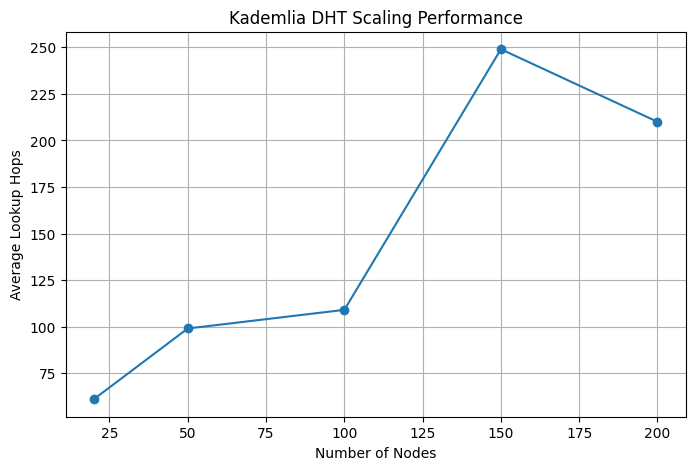

In [12]:

# ---------- Kademlia Core Components ----------

def xor_distance(a, b):
    return a ^ b


class KademliaNode:
    def __init__(self, node_id, k=4):
        self.node_id = node_id
        self.k = k
        self.routing_table = []  # simple list for demonstration
        self.store = {}

    def add_contact(self, node):
        if node not in self.routing_table:
            self.routing_table.append(node)
            if len(self.routing_table) > self.k:
                self.routing_table.pop(0)

    def store_value(self, key, value):
        self.store[key] = value

    def find_value(self, key):
        return self.store.get(key, None)

    def closest_nodes(self, target_id):
        return sorted(
            self.routing_table,
            key=lambda n: xor_distance(n.node_id, target_id)
        )[:self.k]


# ---------- Network Simulation ----------

class KademliaNetwork:
    def __init__(self, num_nodes=50):
        self.nodes = []
        for _ in range(num_nodes):
            node_id = random.getrandbits(16)
            self.nodes.append(KademliaNode(node_id))

        # populate routing tables
        for node in self.nodes:
            for other in random.sample(self.nodes, min(10, len(self.nodes))):
                if node != other:
                    node.add_contact(other)

    def lookup(self, start_node, key):
        start_time = time.time()
        visited = set()
        queue = [start_node]
        hops = 0
        total_messages = 0
        useful_messages = 0

        while queue:
            current = queue.pop(0)
            hops += 1
            total_messages += 1

            if key in current.store:
                useful_messages += 1
                latency = (time.time() - start_time) * 1000
                efficiency = useful_messages / total_messages
                return {
                    "found": True,
                    "value": current.store[key],
                    "hops": hops,
                    "latency_ms": latency,
                    "efficiency": efficiency,
                }

            visited.add(current)

            # expand search
            next_nodes = current.closest_nodes(key)
            for n in next_nodes:
                if n not in visited:
                    queue.append(n)

        latency = (time.time() - start_time) * 1000
        efficiency = useful_messages / total_messages if total_messages else 0

        return {
            "found": False,
            "value": None,
            "hops": hops,
            "latency_ms": latency,
            "efficiency": efficiency,
        }


# ---------- Test the Network ----------
# Simulating a 5G network with distributed nodes
network = KademliaNetwork(num_nodes=100)

# Simulate storing a service endpoint (e.g., edge computing service location)
# In real telecom: this could be a service ID, node address, or content location
target_node = random.choice(network.nodes)
target_key = random.getrandbits(16)
target_node.store_value(target_key, "edge-service-5g-node-42:8080")

# Simulate a node looking up the service (e.g., mobile device finding nearest edge server)
start_node = random.choice(network.nodes)
results = network.lookup(start_node, target_key)
print("Service Discovery Results:", results)
print(f"  Found service at: {results.get('value', 'Not found')}")
print(f"  Network hops required: {results.get('hops', 0)}")
print(f"  Latency: {results.get('latency_ms', 0):.3f} ms")
print(f"  Network efficiency: {results.get('efficiency', 0):.2%}")

# ---------- Plot: Average Hops vs Network Size ----------
sizes = [20, 50, 100, 150, 200]
avg_hops = []

for n in sizes:
    net = KademliaNetwork(num_nodes=n)
    nodeA = random.choice(net.nodes)
    key = random.getrandbits(16)
    nodeA.store_value(key, "value")

    lookup_node = random.choice(net.nodes)
    r = net.lookup(lookup_node, key)
    avg_hops.append(r["hops"])

plt.figure(figsize=(8, 5))
plt.plot(sizes, avg_hops, marker="o")
plt.xlabel("Number of Nodes")
plt.ylabel("Average Lookup Hops")
plt.title("Kademlia DHT Scaling Performance")
plt.grid(True)
plt.show()

### Random walk search

Network Topology Discovery / Fault Detection Result: {'found': False, 'steps': 20, 'latency_ms': 0.0438690185546875, 'efficiency': 0.0}
  Target found: False
  Steps taken: 20
  Latency: 0.044 ms
  Network efficiency: 0.00%


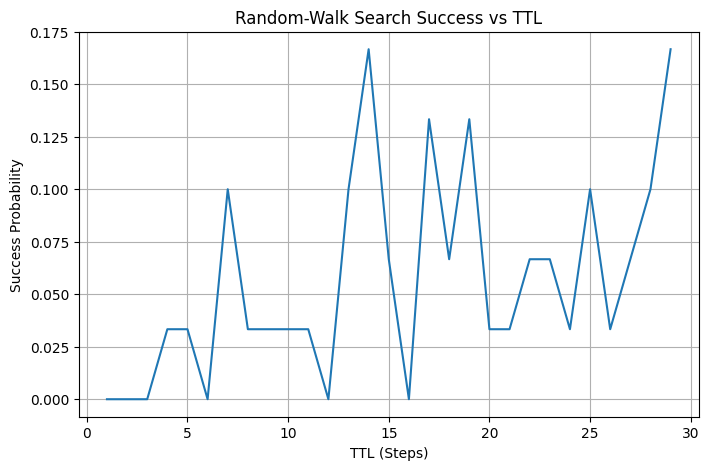

In [15]:


# ---------- Build Graph ----------
G = nx.erdos_renyi_graph(n=100, p=0.05)

# randomly choose a node to hold the target
target = random.choice(list(G.nodes))
G.nodes[target]["data"] = "FOUND"


def random_walk_search(start, ttl=10):
    current = start
    steps = 0
    start_time = time.time()
    total_messages = 0
    useful_messages = 0

    for _ in range(ttl):
        steps += 1
        total_messages += 1

        if "data" in G.nodes[current]:
            useful_messages += 1
            latency = (time.time() - start_time) * 1000
            efficiency = useful_messages / total_messages
            return {
                "found": True,
                "steps": steps,
                "latency_ms": latency,
                "efficiency": efficiency,
            }

        neighbors = list(G.neighbors(current))
        if not neighbors:
            break

        current = random.choice(neighbors)

    latency = (time.time() - start_time) * 1000
    efficiency = useful_messages / total_messages if total_messages else 0
    return {
        "found": False,
        "steps": steps,
        "latency_ms": latency,
        "efficiency": efficiency,
    }


# Test search - simulating fault detection in mobile network
# In real telecom: a network monitoring node searching for faults or resources
start_node = random.choice(list(G.nodes))
res = random_walk_search(start_node, ttl=20)
print("Network Topology Discovery / Fault Detection Result:", res)
print(f"  Target found: {res.get('found', False)}")
print(f"  Steps taken: {res.get('steps', 0)}")
print(f"  Latency: {res.get('latency_ms', 0):.3f} ms")
print(f"  Network efficiency: {res.get('efficiency', 0):.2%}")

# ---------- Success Probability vs TTL ----------
ttls = range(1, 30)
success_rates = []

for ttl in ttls:
    success = 0
    for _ in range(30):  # run multiple trials
        start = random.choice(list(G.nodes))
        r = random_walk_search(start, ttl=ttl)
        if r["found"]:
            success += 1
    success_rates.append(success / 30)

plt.figure(figsize=(8, 5))
plt.plot(ttls, success_rates)
plt.xlabel("TTL (Steps)")
plt.ylabel("Success Probability")
plt.title("Random-Walk Search Success vs TTL")
plt.grid(True)
plt.show()


### Sharded Inverted Index

Search query: 'network'
  Documents found: {1, 3, 5, 6}
  Latency: 0.0017 ms
  Efficiency: 100.00%

Search query: 'mobile'
  Documents found: {2, 6}
  Latency: 0.0012 ms
  Efficiency: 100.00%

Search query: 'distributed'
  Documents found: {2, 4}
  Latency: 0.0007 ms
  Efficiency: 100.00%

Search query: 'error'
  Documents found: {1}
  Latency: 0.0005 ms
  Efficiency: 100.00%



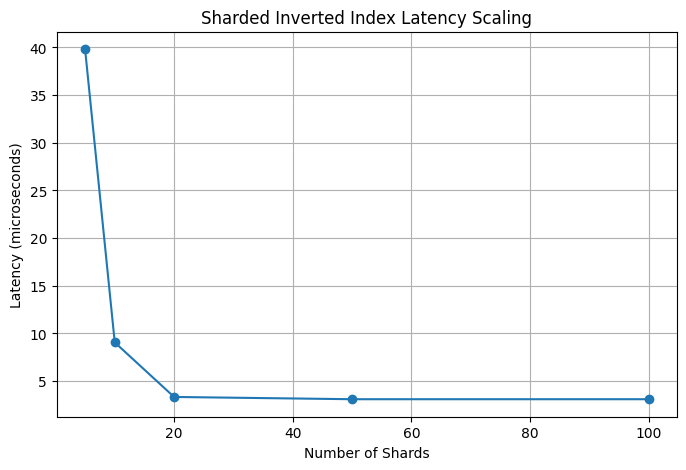

In [16]:
import hashlib

NUM_SHARDS = 5
shards = [dict() for _ in range(NUM_SHARDS)]


def shard_id(word):
    h = int(hashlib.sha1(word.encode()).hexdigest(), 16)
    return h % NUM_SHARDS


# ---------- Ingest Documents ----------
def add_document(doc_id, text):
    words = text.split()
    for w in words:
        s = shard_id(w)
        if w not in shards[s]:
            shards[s][w] = set()
        shards[s][w].add(doc_id)


# sample data - simulating telecom log entries or network event records
docs = {
    1: "5G base station node-42 connection timeout network error",
    2: "mobile subscriber authentication failed distributed system",
    3: "network latency spike detected edge computing node",
    4: "distributed search query processed subscriber database",
    5: "telecommunication network routing table updated",
    6: "mobile network handover completed edge node",
}

for i, text in docs.items():
    add_document(i, text)


# ---------- Query ----------
def search_query(word):
    s = shard_id(word)

    start_time = time.time()
    if word in shards[s]:
        results = shards[s][word]
    else:
        results = set()

    latency = (time.time() - start_time) * 1000
    useful = 1 if results else 0
    efficiency = useful / 1

    return {
        "results": results,
        "latency_ms": latency,
        "efficiency": efficiency,
    }


# Test query - simulating search for network events or log entries
# In real telecom: searching distributed logs for specific network events, errors, or subscriber data
query_terms = ["network", "mobile", "distributed", "error"]
for term in query_terms:
    result = search_query(term)
    print(f"Search query: '{term}'")
    print(f"  Documents found: {result['results']}")
    print(f"  Latency: {result['latency_ms']:.4f} ms")
    print(f"  Efficiency: {result['efficiency']:.2%}")
    print()

# ---------- Latency Scaling Plot ----------
sizes = [5, 10, 20, 50, 100]
latencies = []

for size in sizes:
    temp_shards = [dict() for _ in range(size)]
    word = "distributed"

    start = time.time()
    sid = int(hashlib.sha1(word.encode()).hexdigest(), 16) % size
    check = word in temp_shards[sid]
    latencies.append((time.time() - start) * 1e6)  # microseconds

plt.figure(figsize=(8, 5))
plt.plot(sizes, latencies, marker="o")
plt.xlabel("Number of Shards")
plt.ylabel("Latency (microseconds)")
plt.title("Sharded Inverted Index Latency Scaling")
plt.grid(True)
plt.show()

# DATA PARTITION AND SHARDING ALGORITHMS

Simulating a distributed system using Python, focusing on Hash Partitioning as it provides good load
distribution.

In [17]:
from collections import defaultdict
from typing import Dict, Any, List

# --- Configuration ---
NUM_SHARDS = 4  # N
DATA_SIZE = 10000

# --- Sharding Algorithm ---
def get_shard_index(record_id: int) -> int:
    """Uses hash partitioning to map a record ID to a shard index."""
    hash_object = hashlib.md5(str(record_id).encode())
    hash_int = int(hash_object.hexdigest(), 16)
    return hash_int % NUM_SHARDS

# --- Simulated Environment ---
class Shard:
    """Represents an independent database instance (shard node)."""
    def __init__(self, index: int):
        self.index = index
        self.data: Dict[int, Any] = {}
        self.latency_ms = random.randint(10, 50)  # Simulated base processing latency

    def store_record(self, record_id: int, data: Any):
        """Simulates storing data with associated latency."""
        time.sleep(self.latency_ms / 1000.0) # Simulate I/O and processing time
        self.data[record_id] = data
        return True

    def retrieve_record(self, record_id: int):
        """Simulates retrieving data."""
        time.sleep(self.latency_ms / 1000.0)
        return self.data.get(record_id)

class DistributedSystem:
    """Manages the collection of shards and coordinates operations."""
    def __init__(self, num_shards: int):
        self.shards: List[Shard] = [Shard(i) for i in range(num_shards)]
        print(f" Initialized Distributed System with {num_shards} Shards.")

    def route_and_store(self, record_id: int, data: Any):
        """Routes the record to the correct shard and stores it."""
        shard_index = get_shard_index(record_id)
        shard = self.shards[shard_index]
        return shard.store_record(record_id, data)

    def route_and_retrieve(self, record_id: int):
        """Routes the request to the correct shard and retrieves the record."""
        shard_index = get_shard_index(record_id)
        shard = self.shards[shard_index]
        return shard.retrieve_record(record_id)

# --- Simulation Execution ---
def run_simulation():
    system = DistributedSystem(NUM_SHARDS)

    # 1. Data Distribution (Initial Load/Write Operations)
    start_time = time.perf_counter()
    for i in range(DATA_SIZE):
        record_id = i + 1
        data = {"value": f"data_for_{record_id}"}
        system.route_and_store(record_id, data)
    end_time = time.perf_counter()

    total_latency_write = (end_time - start_time)
    throughput_write = DATA_SIZE / total_latency_write

    print("\n--- Initial Load Metrics ---")
    print(f"Total Write Time (Latency): {total_latency_write:.4f} seconds")
    print(f"Write Throughput: {throughput_write:.2f} records/second")

    # Check data distribution (Network Efficiency)
    shard_counts = defaultdict(int)
    for i in range(1, DATA_SIZE + 1):
        shard_counts[get_shard_index(i)] += 1

    print("\n--- Data Distribution Check (Network Efficiency) ---")
    for index, count in shard_counts.items():
        print(f"Shard {index}: {count} records ({count/DATA_SIZE*100:.2f}%)")

    # 2. Query Simulation (Read Operations)
    READ_QUERIES = 500
    query_ids = random.sample(range(1, DATA_SIZE + 1), READ_QUERIES)

    start_time_read = time.perf_counter()
    for record_id in query_ids:
        system.route_and_retrieve(record_id)
    end_time_read = time.perf_counter()

    total_latency_read = (end_time_read - start_time_read)
    throughput_read = READ_QUERIES / total_latency_read

    print("\n--- Query Metrics ---")
    print(f"Total Read Time (Latency): {total_latency_read:.4f} seconds")
    print(f"Read Throughput: {throughput_read:.2f} queries/second")

if __name__ == '__main__':
    run_simulation()

 Initialized Distributed System with 4 Shards.

--- Initial Load Metrics ---
Total Write Time (Latency): 331.8812 seconds
Write Throughput: 30.13 records/second

--- Data Distribution Check (Network Efficiency) ---
Shard 3: 2549 records (25.49%)
Shard 0: 2518 records (25.18%)
Shard 1: 2460 records (24.60%)
Shard 2: 2473 records (24.73%)

--- Query Metrics ---
Total Read Time (Latency): 16.9614 seconds
Read Throughput: 29.48 queries/second


# LOAD BALANCING AND FAULT TOLERANCE

In [1]:
import time
import random

# --- 1. SETUP: SIMULATING MULTIPLE NODES ---
# We simulate 3 servers in a distributed cluster
# In real life, these would be separate physical machines.
NODES = [
    {"name": "Server_Alpha", "status": "ONLINE"},
    {"name": "Server_Beta",  "status": "ONLINE"},
    {"name": "Server_Gamma", "status": "ONLINE"}
]

TOTAL_REQUESTS = 10  # Total calls to simulate

print("--- STARTING TELECOM CLUSTER SIMULATION ---")
print(f"Nodes Available: {len(NODES)}")
print("-" * 50)

# Variables for Metrics
latencies = []
successful_requests = 0
start_simulation_time = time.time() # Start timer for Throughput

# --- 2. SIMULATING ALGORITHM EXECUTION ---
# We loop through requests to simulate incoming traffic
for i in range(TOTAL_REQUESTS):
    req_id = i + 1

    # Round Robin Logic: Select node based on index (0, 1, 2, 0...)
    node_index = i % len(NODES)
    selected_node = NODES[node_index]

    # --- SIMULATE FAULT TOLERANCE ---
    # Scenario: Server_Beta crashes at Request #5
    if req_id == 5:
        print(f"\n[ALERT] {NODES[1]['name']} has CRASHED! (Simulating Failure)")
        NODES[1]["status"] = "OFFLINE"

    # Check if node is dead. If so, FAULT TOLERANCE reroutes traffic.
    if selected_node["status"] == "OFFLINE":
        print(f" -> {selected_node['name']} is down. Rerouting to next node...")
        # Reroute to the next available node (simple failover)
        node_index = (node_index + 1) % len(NODES)
        selected_node = NODES[node_index]

    try:
        # --- 3. MEASURING PERFORMANCE METRICS ---

        # [METRIC 1] LATENCY: Time taken to process ONE request
        req_start_time = time.time()

        # Simulate work (Network Jitter)
        process_time = random.uniform(0.1, 0.4)
        time.sleep(process_time)

        req_end_time = time.time()

        # Calculate Latency
        latency = req_end_time - req_start_time
        latencies.append(latency)
        successful_requests += 1

        print(f"Req #{req_id} -> Processed by {selected_node['name']} | Latency: {latency:.4f}s")

    except Exception as e:
        print(f"Req #{req_id} FAILED.")

# --- 4. CALCULATING FINAL METRICS ---
end_simulation_time = time.time()
total_duration = end_simulation_time - start_simulation_time

# [METRIC 2] NETWORK EFFICIENCY: % of requests handled vs dropped
# If Fault Tolerance works, this should be 100% even with a crash.
network_efficiency = (successful_requests / TOTAL_REQUESTS) * 100

# [METRIC 3] THROUGHPUT: Requests per second
# How much load can the system handle?
throughput = successful_requests / total_duration
avg_latency = sum(latencies) / len(latencies)

# --- 5. FINAL REPORT (Output for Assignment) ---
print("-" * 50)
print("PERFORMANCE METRICS REPORT")
print("-" * 50)
print(f"1. Network Efficiency: {network_efficiency:.2f}%")
print(f"   (Did we lose data? 100% means No.)")
print(f"2. Average Latency:    {avg_latency:.4f} seconds")
print(f"   (How fast was the response?)")
print(f"3. System Throughput:  {throughput:.2f} requests/sec")
print(f"   (Capacity of the simulated network)")
print("-" * 50)

--- STARTING TELECOM CLUSTER SIMULATION ---
Nodes Available: 3
--------------------------------------------------
Req #1 -> Processed by Server_Alpha | Latency: 0.2747s
Req #2 -> Processed by Server_Beta | Latency: 0.2541s
Req #3 -> Processed by Server_Gamma | Latency: 0.3734s
Req #4 -> Processed by Server_Alpha | Latency: 0.3473s

[ALERT] Server_Beta has CRASHED! (Simulating Failure)
 -> Server_Beta is down. Rerouting to next node...
Req #5 -> Processed by Server_Gamma | Latency: 0.3374s
Req #6 -> Processed by Server_Gamma | Latency: 0.2509s
Req #7 -> Processed by Server_Alpha | Latency: 0.3692s
 -> Server_Beta is down. Rerouting to next node...
Req #8 -> Processed by Server_Gamma | Latency: 0.2811s
Req #9 -> Processed by Server_Gamma | Latency: 0.1915s
Req #10 -> Processed by Server_Alpha | Latency: 0.3010s
--------------------------------------------------
PERFORMANCE METRICS REPORT
--------------------------------------------------
1. Network Efficiency: 100.00%
   (Did we lose dat

#CONSENSUS ALGORITHMS

Raft algorithm demo

In [2]:
import threading
import time
import random
import queue
from dataclasses import dataclass, field
from typing import List, Dict, Optional

# --- CONFIGURATION ---
NUM_NODES = 5
SIMULATION_TIME = 10  # Seconds
NETWORK_DELAY_MIN = 0.01
NETWORK_DELAY_MAX = 0.05

# --- MESSAGING STRUCTURE ---
@dataclass
class LogEntry:
    term: int
    command: str

@dataclass
class Message:
    sender: int
    receiver: int
    msg_type: str  # "RequestVote", "VoteGranted", "AppendEntries", "Heartbeat"
    term: int
    payload: Optional[any] = None
    timestamp: float = field(default_factory=time.time)

# --- NETWORK SIMULATOR ---
class Network:
    """Simulates a network with latency and message passing."""
    def __init__(self):
        self.queues: Dict[int, queue.Queue] = {i: queue.Queue() for i in range(NUM_NODES)}
        self.lock = threading.Lock()
        self.total_messages = 0

    def send(self, msg: Message):
        """Simulates network delay before delivering message."""
        def delivery():
            delay = random.uniform(NETWORK_DELAY_MIN, NETWORK_DELAY_MAX)
            time.sleep(delay)
            if msg.receiver in self.queues:
                self.queues[msg.receiver].put(msg)
                with self.lock:
                    self.total_messages += 1

        # Run delivery in a separate thread to not block the sender
        t = threading.Thread(target=delivery)
        t.daemon = True
        t.start()

    def receive(self, node_id) -> Optional[Message]:
        try:
            return self.queues[node_id].get_nowait()
        except queue.Empty:
            return None

# --- RAFT NODE IMPLEMENTATION ---
class Node(threading.Thread):
    def __init__(self, node_id, network, monitor):
        super().__init__()
        self.node_id = node_id
        self.network = network
        self.monitor = monitor
        self.running = True

        # State
        self.state = "Follower" # Follower, Candidate, Leader
        self.term = 0
        self.voted_for = None
        self.log: List[LogEntry] = []
        self.commit_index = 0
        self.votes_received = 0

        # Timers
        self.last_heartbeat = time.time()
        # Random timeout to prevent split votes (150-300ms logic)
        self.election_timeout = random.uniform(0.15, 0.30)

    def run(self):
        """Main event loop for the node."""
        while self.running:
            # 1. Process Incoming Messages
            msg = self.network.receive(self.node_id)
            if msg:
                self.handle_message(msg)

            # 2. Check Election Timeout (If Follower or Candidate)
            if self.state != "Leader":
                if time.time() - self.last_heartbeat > self.election_timeout:
                    self.start_election()

            # 3. Send Heartbeats (If Leader)
            if self.state == "Leader":
                self.send_heartbeats()
                time.sleep(0.05) # Heartbeat interval 50ms

            time.sleep(0.001) # CPU yielding

    def start_election(self):
        self.state = "Candidate"
        self.term += 1
        self.voted_for = self.node_id
        self.votes_received = 1 # Vote for self
        self.last_heartbeat = time.time()
        self.election_timeout = random.uniform(0.15, 0.30) # Reset timer

        print(f"[Node {self.node_id}] Timeout! Starting Election for Term {self.term}")

        # Broadcast RequestVote
        for peer in range(NUM_NODES):
            if peer != self.node_id:
                msg = Message(self.node_id, peer, "RequestVote", self.term)
                self.network.send(msg)

    def handle_message(self, msg: Message):
        # Universal Logic: If we see a higher term, revert to Follower
        if msg.term > self.term:
            self.state = "Follower"
            self.term = msg.term
            self.voted_for = None

        if msg.msg_type == "RequestVote":
            self.handle_request_vote(msg)
        elif msg.msg_type == "VoteGranted":
            self.handle_vote_granted(msg)
        elif msg.msg_type == "Heartbeat" or msg.msg_type == "AppendEntries":
            self.handle_append_entries(msg)

    def handle_request_vote(self, msg: Message):
        if msg.term >= self.term and (self.voted_for is None or self.voted_for == msg.sender):
            self.voted_for = msg.sender
            self.last_heartbeat = time.time() # Reset timeout
            grant_msg = Message(self.node_id, msg.sender, "VoteGranted", self.term)
            self.network.send(grant_msg)

    def handle_vote_granted(self, msg: Message):
        if self.state == "Candidate" and msg.term == self.term:
            self.votes_received += 1
            if self.votes_received > NUM_NODES / 2:
                self.become_leader()

    def become_leader(self):
        if self.state != "Leader":
            self.state = "Leader"
            print(f"--- [Node {self.node_id}] BECAME LEADER for Term {self.term} ---")
            # Notify monitor for metrics
            self.monitor.record_leader_election(self.node_id, self.term)
            self.send_heartbeats()

    def send_heartbeats(self):
        for peer in range(NUM_NODES):
            if peer != self.node_id:
                # In a real impl, we would send log entries here
                msg = Message(self.node_id, peer, "Heartbeat", self.term, payload=self.log)
                self.network.send(msg)

    def handle_append_entries(self, msg: Message):
        self.state = "Follower"
        self.last_heartbeat = time.time()

        # Simple Log replication logic
        if msg.payload and len(msg.payload) > len(self.log):
            new_entries = msg.payload[len(self.log):]
            self.log.extend(new_entries)
            print(f"[Node {self.node_id}] Replicated log: {new_entries[-1].command}")
            # Notify monitor that data is replicated
            self.monitor.record_commit()

    def stop(self):
        self.running = False

# --- MONITORING & METRICS ---
class Monitor:
    def __init__(self):
        self.election_times = []
        self.commits = 0
        self.start_time = time.time()
        self.leader_active = False

    def record_leader_election(self, node_id, term):
        self.election_times.append(time.time())
        self.leader_active = True

    def record_commit(self):
        self.commits += 1

# --- MAIN SIMULATION ---
if __name__ == "__main__":
    print(f"Starting Telecom Consensus Simulation ({NUM_NODES} Nodes)...")

    network = Network()
    monitor = Monitor()
    nodes = [Node(i, network, monitor) for i in range(NUM_NODES)]

    # 1. Start Nodes
    for n in nodes:
        n.start()

    # 2. Let simulation run for a bit to allow Leader Election
    time.sleep(2)

    # 3. Simulate Client Request (Telecom Use Case: Update Subscriber Profile)
    leader = next((n for n in nodes if n.state == "Leader"), None)
    if leader:
        print(f"\n>>> CLIENT REQUEST: Sending 'UPDATE_SUB_5G_PROFILE' to Leader {leader.node_id}")
        start_req_time = time.time()

        # Append to leader's log
        entry = LogEntry(term=leader.term, command="UPDATE_SUB_5G_PROFILE")
        leader.log.append(entry)

        # Allow time for replication
        time.sleep(2)
        latency = (time.time() - start_req_time) * 1000
        print(f">>> Request Processed. Estimated Latency: {latency:.2f} ms\n")
    else:
        print("\n>>> No Leader Elected yet (Network unstable?)\n")

    # 4. Stop Simulation
    time.sleep(SIMULATION_TIME - 4)
    for n in nodes:
        n.stop()
    for n in nodes:
        n.join()

    # 5. Report Metrics
    print("\n" + "="*40)
    print("SIMULATION PERFORMANCE REPORT")
    print("="*40)

    total_time = time.time() - monitor.start_time
    # Estimate throughput based on total heartbeats/messages processed
    throughput = network.total_messages / total_time

    print(f"Total Simulation Time : {total_time:.2f} s")
    print(f"Total Messages Exchanged: {network.total_messages}")
    print(f"Network Throughput      : {throughput:.2f} msgs/sec")
    print(f"Successful Log Commits  : {monitor.commits} (Replicated across nodes)")
    print(f"Elections Held          : {len(monitor.election_times)}")
    print("="*40)

Starting Telecom Consensus Simulation (5 Nodes)...
[Node 0] Timeout! Starting Election for Term 1
[Node 4] Timeout! Starting Election for Term 1
--- [Node 0] BECAME LEADER for Term 1 ---

>>> CLIENT REQUEST: Sending 'UPDATE_SUB_5G_PROFILE' to Leader 0
[Node 4] Replicated log: UPDATE_SUB_5G_PROFILE
[Node 2] Replicated log: UPDATE_SUB_5G_PROFILE
[Node 3] Replicated log: UPDATE_SUB_5G_PROFILE
[Node 1] Replicated log: UPDATE_SUB_5G_PROFILE
>>> Request Processed. Estimated Latency: 2000.10 ms


SIMULATION PERFORMANCE REPORT
Total Simulation Time : 10.03 s
Total Messages Exchanged: 755
Network Throughput      : 75.30 msgs/sec
Successful Log Commits  : 4 (Replicated across nodes)
Elections Held          : 1
